In [22]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from deepposekit.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from deepposekit.callbacks import Logger, ModelCheckpoint


import time
from os.path import expanduser

In [13]:
image_path = "C:\\Users\\exley\\Desktop\\CDME\\RobotPose\\data\\2d"
ds_path = "C:\\Users\\exley\\Desktop\\CDME\\RobotPose\\data\\ds.h5"
skeleton_path = "C:\\Users\\exley\\Desktop\\CDME\\RobotPose\\data\\skeleton.csv"
log_path = "C:\\Users\\exley\\Desktop\\CDME\\RobotPose\\data\\log.h5"
model_path = "C:\\Users\\exley\\Desktop\\CDME\\RobotPose\\data\\model_dense.h5"


data_generator = DataGenerator(ds_path)

In [14]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=None,
                                    sigma=5,
                                    validation_split=0.1, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 90,
 'n_validation': 10,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (120, 160),
 'n_output_channels': 10,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': False,
 'datapath': 'C:\\Users\\exley\\Desktop\\CDME\\RobotPose\\data\\ds.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 100,
 'image_shape': (480, 640, 3),
 'keypoints_shape': (4, 2)}

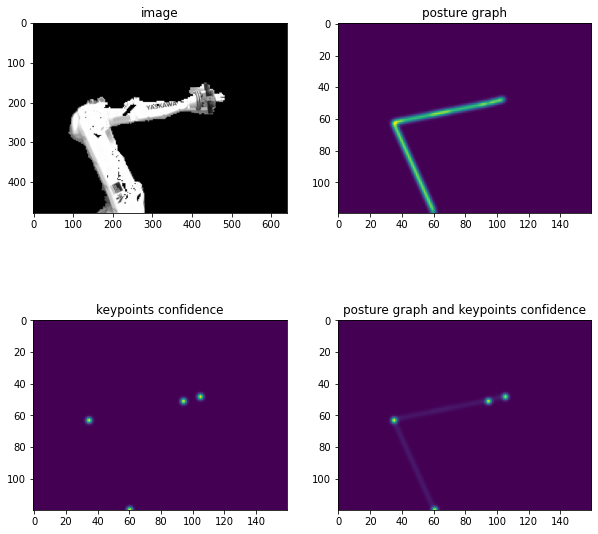

In [15]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

In [17]:
from deepposekit.models import DeepLabCut, StackedDenseNet, StackedHourglass, LEAP


In [18]:

model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)

#model = DeepLabCut(train_generator, backbone="resnet50")
#model = DeepLabCut(train_generator, backbone="mobilenetv2", alpha=0.35) # Increase alpha to improve accuracy
#model = DeepLabCut(train_generator, backbone="densenet121")

#model = LEAP(train_generator)
#model = StackedHourglass(train_generator)

model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 5,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 90,
 'n_validation': 10,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (120, 160),
 'n_output_channels': 10,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': False,
 'datapath': 'C:\\Users\\exley\\Desktop\\CDME\\RobotPose\\data\\ds.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 100,
 'image_shape': (480, 640, 3),
 'keypoints_shape': (4, 2)}

In [19]:
data_size = (10,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:100], batch_size=100) # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=100, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

1/1 [==============================] - 0s 997us/step
3.511879448612929


In [20]:
logger = Logger(validation_batch_size=2,
    # filepath saves the logger data to a .h5 file
    filepath=log_path
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=1, patience=20)

model_checkpoint = ModelCheckpoint(
    model_path,
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    verbose=1,
    save_best_only=True,
)

early_stop = EarlyStopping(
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    min_delta=0.001,
    patience=100,
    verbose=1
)

callbacks = [early_stop, reduce_lr, model_checkpoint, logger]

In [21]:
model.fit(
    batch_size=4,
    validation_batch_size=2,
    callbacks=callbacks,
    #epochs=1000, # Increase the number of epochs to train the model longer
    epochs=1000,
    n_workers=8,
    steps_per_epoch=None,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000
22/22 [==============================] - ETA: 0s - loss: 40.4546 - output_0_loss: 13.7479 - output_1_loss: 13.4560 - output_2_loss: 13.2507

AttributeError: 'StackedDenseNet' object has no attribute 'distribute_strategy'